In [29]:
import numpy as np
import pandas as pd
import cv2
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [30]:
import zipfile
import os
zip_path = "images_dataset.zip"  
extract_path = "./extracted_data" 
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(f"Files extracted to: {extract_path}")

Files extracted to: ./extracted_data


define base paths

In [31]:
import os

base_path = "./extracted_data"
odir_path = os.path.join(base_path, "ODIR-5K")
training_images_path = os.path.join(odir_path, "Training Images")
testing_images_path = os.path.join(odir_path, "Testing Images")
excel_file_path = os.path.join(odir_path, "data.xlsx")
csv_file_path = os.path.join(base_path, "full_df.csv")

print(f"Base Path: {base_path}")
print(f"ODIR Path: {odir_path}")
print(f"Training Images Path: {training_images_path}")
print(f"Testing Images Path: {testing_images_path}")
print(f"Excel File Path: {excel_file_path}")
print(f"CSV File Path: {csv_file_path}")


Base Path: ./extracted_data
ODIR Path: ./extracted_data/ODIR-5K
Training Images Path: ./extracted_data/ODIR-5K/Training Images
Testing Images Path: ./extracted_data/ODIR-5K/Testing Images
Excel File Path: ./extracted_data/ODIR-5K/data.xlsx
CSV File Path: ./extracted_data/full_df.csv


In [33]:
import os

odir_path = "./extracted_data/ODIR-5K"


load metadata

In [34]:
import pandas as pd

excel_file_path = "./extracted_data/ODIR-5K/ODIR-5K/data.xlsx"

try:
    df = pd.read_excel(excel_file_path)
    print(f"DataFrame loaded successfully. Shape: {df.shape}")
    print(df.head())
except UnicodeDecodeError:
    print("Error: File is not UTF-8 encoded. Attempting alternative solutions.")

DataFrame loaded successfully. Shape: (3500, 15)
   ID  Patient Age Patient Sex Left-Fundus Right-Fundus  \
0   0           69      Female  0_left.jpg  0_right.jpg   
1   1           57        Male  1_left.jpg  1_right.jpg   
2   2           42        Male  2_left.jpg  2_right.jpg   
3   3           66        Male  3_left.jpg  3_right.jpg   
4   4           53        Male  4_left.jpg  4_right.jpg   

                            Left-Diagnostic Keywords  \
0                                           cataract   
1                                      normal fundus   
2  laser spot，moderate non proliferative retinopathy   
3                                      normal fundus   
4                        macular epiretinal membrane   

                Right-Diagnostic Keywords  N  D  G  C  A  H  M  O  
0                           normal fundus  0  0  0  1  0  0  0  0  
1                           normal fundus  1  0  0  0  0  0  0  0  
2  moderate non proliferative retinopathy  0  1  0  0  

In [35]:
import pandas as pd

csv_path = os.path.join(extract_path, "full_df.csv") 
df = pd.read_csv(csv_path)

print(df.head())


   ID  Patient Age Patient Sex Left-Fundus Right-Fundus  \
0   0           69      Female  0_left.jpg  0_right.jpg   
1   1           57        Male  1_left.jpg  1_right.jpg   
2   2           42        Male  2_left.jpg  2_right.jpg   
3   4           53        Male  4_left.jpg  4_right.jpg   
4   5           50      Female  5_left.jpg  5_right.jpg   

                            Left-Diagnostic Keywords  \
0                                           cataract   
1                                      normal fundus   
2  laser spot，moderate non proliferative retinopathy   
3                        macular epiretinal membrane   
4             moderate non proliferative retinopathy   

                Right-Diagnostic Keywords  N  D  G  C  A  H  M  O  \
0                           normal fundus  0  0  0  1  0  0  0  0   
1                           normal fundus  1  0  0  0  0  0  0  0   
2  moderate non proliferative retinopathy  0  1  0  0  0  0  0  1   
3       mild nonproliferative re

add file paths for images

In [36]:
print(df.head())
print("Columns in DataFrame:", df.columns)

   ID  Patient Age Patient Sex Left-Fundus Right-Fundus  \
0   0           69      Female  0_left.jpg  0_right.jpg   
1   1           57        Male  1_left.jpg  1_right.jpg   
2   2           42        Male  2_left.jpg  2_right.jpg   
3   4           53        Male  4_left.jpg  4_right.jpg   
4   5           50      Female  5_left.jpg  5_right.jpg   

                            Left-Diagnostic Keywords  \
0                                           cataract   
1                                      normal fundus   
2  laser spot，moderate non proliferative retinopathy   
3                        macular epiretinal membrane   
4             moderate non proliferative retinopathy   

                Right-Diagnostic Keywords  N  D  G  C  A  H  M  O  \
0                           normal fundus  0  0  0  1  0  0  0  0   
1                           normal fundus  1  0  0  0  0  0  0  0   
2  moderate non proliferative retinopathy  0  1  0  0  0  0  0  1   
3       mild nonproliferative re

In [37]:
print("Missing Left-Fundus values:", df["Left-Fundus"].isnull().sum())
print("Missing Right-Fundus values:", df["Right-Fundus"].isnull().sum())

df = df.dropna(subset=["Left-Fundus", "Right-Fundus"])

print(f"DataFrame shape after removing missing rows: {df.shape}")

Missing Left-Fundus values: 0
Missing Right-Fundus values: 0
DataFrame shape after removing missing rows: (6392, 19)


In [38]:
import os

training_images_path = "./extracted_data/ODIR-5K/ODIR-5K/Training Images"
if os.path.exists(training_images_path):
    training_files = os.listdir(training_images_path)
    print(f"Total files in Training Images directory: {len(training_files)}")
    print("Sample files:", training_files[:10])
else:
    print(f"Directory not found: {training_images_path}")

print("Sample Left-Fundus filenames from DataFrame:")
print(df["Left-Fundus"].head())

missing_files = df["Left-Fundus"].apply(lambda x: x not in training_files).sum()
print(f"Number of Left-Fundus files not found in directory: {missing_files}")

Total files in Training Images directory: 7000
Sample files: ['261_left.jpg', '2342_left.jpg', '806_right.jpg', '4227_right.jpg', '2124_left.jpg', '1402_right.jpg', '201_right.jpg', '2125_left.jpg', '1919_right.jpg', '4011_right.jpg']
Sample Left-Fundus filenames from DataFrame:
0    0_left.jpg
1    1_left.jpg
2    2_left.jpg
3    4_left.jpg
4    5_left.jpg
Name: Left-Fundus, dtype: object
Number of Left-Fundus files not found in directory: 0


normalizing file names

In [39]:
df["Left-Fundus"] = df["Left-Fundus"].str.lower()
df["Right-Fundus"] = df["Right-Fundus"].str.lower()


In [40]:
df["left_filepath"] = df["Left-Fundus"].apply(lambda x: os.path.join(training_images_path, x))
df["right_filepath"] = df["Right-Fundus"].apply(lambda x: os.path.join(training_images_path, x))

print(df[["Left-Fundus", "left_filepath"]].head())
print(df[["Right-Fundus", "right_filepath"]].head())

  Left-Fundus                                      left_filepath
0  0_left.jpg  ./extracted_data/ODIR-5K/ODIR-5K/Training Imag...
1  1_left.jpg  ./extracted_data/ODIR-5K/ODIR-5K/Training Imag...
2  2_left.jpg  ./extracted_data/ODIR-5K/ODIR-5K/Training Imag...
3  4_left.jpg  ./extracted_data/ODIR-5K/ODIR-5K/Training Imag...
4  5_left.jpg  ./extracted_data/ODIR-5K/ODIR-5K/Training Imag...
  Right-Fundus                                     right_filepath
0  0_right.jpg  ./extracted_data/ODIR-5K/ODIR-5K/Training Imag...
1  1_right.jpg  ./extracted_data/ODIR-5K/ODIR-5K/Training Imag...
2  2_right.jpg  ./extracted_data/ODIR-5K/ODIR-5K/Training Imag...
3  4_right.jpg  ./extracted_data/ODIR-5K/ODIR-5K/Training Imag...
4  5_right.jpg  ./extracted_data/ODIR-5K/ODIR-5K/Training Imag...


In [41]:
df["left_exists"] = df["left_filepath"].apply(os.path.exists)
df["right_exists"] = df["right_filepath"].apply(os.path.exists)
df = df[df["left_exists"] & df["right_exists"]]
print(f"DataFrame shape after filtering invalid paths: {df.shape}")

DataFrame shape after filtering invalid paths: (6392, 23)


PREPROCESS IMAGES

In [42]:
import cv2
import numpy as np
from tqdm import tqdm

def batch_preprocess_images(filepaths, batch_size=100, target_size=(224, 224)):
    
    images = []
    for i in range(0, len(filepaths), batch_size):
        batch = filepaths[i:i+batch_size]
        batch_images = []
        for path in batch:
            try:
               
                image = cv2.imread(path, cv2.IMREAD_COLOR)
                if image is None:
                    print(f"Image not found or unreadable: {path}")
                    continue
                image = cv2.resize(image, target_size)
                batch_images.append(image / 255.0) 
            except Exception as e:
                print(f"Error processing image {path}: {e}")
                continue
      
        if batch_images:
            images.append(np.array(batch_images))
    return np.concatenate(images, axis=0) if images else np.array([])


In [43]:
image_size = 224
batch_size = 100
print("Processing Left-Fundus images...")
X_left = batch_preprocess_images(df["left_filepath"].values, batch_size=batch_size, target_size=(image_size, image_size))
print(f"Processed Left-Fundus images. Shape: {X_left.shape}")

print("Processing Right-Fundus images...")
X_right = batch_preprocess_images(df["right_filepath"].values, batch_size=batch_size, target_size=(image_size, image_size))
print(f"Processed Right-Fundus images. Shape: {X_right.shape}")


Processing Left-Fundus images...
Processed Left-Fundus images. Shape: (6392, 224, 224, 3)
Processing Right-Fundus images...
Processed Right-Fundus images. Shape: (6392, 224, 224, 3)


create labels

In [44]:
def has_cataract(text):
    return 1 if "cataract" in text.lower() else 0

# Create labels for left and right eyes
df["left_cataract"] = df["Left-Diagnostic Keywords"].apply(has_cataract)
df["right_cataract"] = df["Right-Diagnostic Keywords"].apply(has_cataract)

# Combine labels for binary classification
y = (df["left_cataract"] | df["right_cataract"]).values 

print(f"Labels shape: {y.shape}")


Labels shape: (6392,)


train-test split

In [45]:
print(f"X_left shape: {X_left.shape if 'X_left' in locals() else 'Not defined'}")
print(f"X_right shape: {X_right.shape if 'X_right' in locals() else 'Not defined'}")


X_left shape: (6392, 224, 224, 3)
X_right shape: (6392, 224, 224, 3)


In [46]:
X = X_left 

In [47]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training data: {X_train.shape}, {y_train.shape}")
print(f"Testing data: {X_test.shape}, {y_test.shape}")


Training data: (5113, 224, 224, 3), (5113,)
Testing data: (1279, 224, 224, 3), (1279,)


In [48]:

def has_cataract(text):
    if "cataract" in text.lower(): 
        return 1
    else:
        return 0

# Create new columns for left and right cataract
df["left_cataract"] = df["Left-Diagnostic Keywords"].apply(lambda x: has_cataract(x))
df["right_cataract"] = df["Right-Diagnostic Keywords"].apply(lambda x: has_cataract(x))

# Print the count of right cataract samples
print("Right cataract sample counts:")
print(df["right_cataract"].value_counts())


Right cataract sample counts:
0    6102
1     290
Name: right_cataract, dtype: int64


extract catract and normal images

In [49]:
# Extract filenames for cataract images
left_cataract = df.loc[(df.C == 1) & (df.left_cataract == 1)]["Left-Fundus"].values
right_cataract = df.loc[(df.C == 1) & (df.right_cataract == 1)]["Right-Fundus"].values

# Print a few filenames
print("Left cataract filenames:", left_cataract[:10])
print("Right cataract filenames:", right_cataract[:15])

# Print the number of images in left and right cataract
print(f"Number of images in left cataract: {len(left_cataract)}")
print(f"Number of images in right cataract: {len(right_cataract)}")

# Sample filenames for normal fundus images
left_normal = df.loc[(df.C == 0) & (df["Left-Diagnostic Keywords"] == "normal fundus")]["Left-Fundus"].sample(300, random_state=42).values
right_normal = df.loc[(df.C == 0) & (df["Right-Diagnostic Keywords"] == "normal fundus")]["Right-Fundus"].sample(300, random_state=42).values

# Print a few filenames
print("Right normal fundus filenames:", right_normal[:15])


Left cataract filenames: ['0_left.jpg' '81_left.jpg' '103_left.jpg' '119_left.jpg' '254_left.jpg'
 '294_left.jpg' '330_left.jpg' '448_left.jpg' '465_left.jpg'
 '477_left.jpg']
Right cataract filenames: ['24_right.jpg' '81_right.jpg' '112_right.jpg' '188_right.jpg'
 '218_right.jpg' '345_right.jpg' '354_right.jpg' '477_right.jpg'
 '553_right.jpg' '560_right.jpg' '625_right.jpg' '726_right.jpg'
 '769_right.jpg' '949_right.jpg' '955_right.jpg']
Number of images in left cataract: 304
Number of images in right cataract: 290
Right normal fundus filenames: ['2964_right.jpg' '680_right.jpg' '500_right.jpg' '2368_right.jpg'
 '2820_right.jpg' '2769_right.jpg' '2696_right.jpg' '2890_right.jpg'
 '940_right.jpg' '2553_right.jpg' '3371_right.jpg' '3042_right.jpg'
 '919_right.jpg' '3427_right.jpg' '379_right.jpg']


concatenate file names

In [50]:
# Concatenate filenames for cataract and normal samples
cataract = np.concatenate((left_cataract, right_cataract), axis=0)
normal = np.concatenate((left_normal, right_normal), axis=0)

# Print the number of cataract and normal images
print(f"Total cataract images: {len(cataract)}")
print(f"Total normal images: {len(normal)}")


Total cataract images: 594
Total normal images: 600


create dataset

In [52]:
dataset_dir = "./extracted_data/ODIR-5K/ODIR-5K/Training Images"

In [53]:

missing_files = [file for file in cataract if file not in os.listdir(dataset_dir)]
print(f"Number of missing files: {len(missing_files)}")
if missing_files:
    print(f"Sample missing files: {missing_files[:5]}")


Number of missing files: 0


In [54]:
df["Left-Fundus"] = df["Left-Fundus"].str.lower()
df["Right-Fundus"] = df["Right-Fundus"].str.lower()


In [55]:
df["Left-Fundus"] = df["Left-Fundus"].str.replace(".jpg", ".png")
df["Right-Fundus"] = df["Right-Fundus"].str.replace(".jpg", ".png")


/var/folders/_n/kvf9q33n3794gylfrmxv06v00000gn/T/ipykernel_3154/4245991272.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  df["Left-Fundus"] = df["Left-Fundus"].str.replace(".jpg", ".png")
/var/folders/_n/kvf9q33n3794gylfrmxv06v00000gn/T/ipykernel_3154/4245991272.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df["Right-Fundus"] = df["Right-Fundus"].str.replace(".jpg", ".png")


In [56]:
df["left_filepath"] = df["Left-Fundus"].apply(lambda x: os.path.join(dataset_dir, x))
df["right_filepath"] = df["Right-Fundus"].apply(lambda x: os.path.join(dataset_dir, x))

# Filter rows with valid file paths
df = df[df["left_filepath"].apply(os.path.exists)]
df = df[df["right_filepath"].apply(os.path.exists)]

print(f"Filtered DataFrame shape: {df.shape}")


Filtered DataFrame shape: (0, 0)


In [57]:
def create_dataset(image_category, label, dataset_dir, image_size=224):
    dataset = []
    invalid_images = []  
    for img in tqdm(image_category, desc="Processing Images"):
        image_path = os.path.join(dataset_dir, img)
        try:
            
            print(f"Processing: {image_path}")
          
            if not os.path.exists(image_path):
                print(f"Warning: File not found: {image_path}")
                invalid_images.append(img)
                continue

            image = cv2.imread(image_path, cv2.IMREAD_COLOR)
            if image is None:
                print(f"Warning: Cannot read image: {image_path}")
                invalid_images.append(img)
                continue

            image = cv2.resize(image, (image_size, image_size))
            dataset.append([np.array(image), np.array(label)])
        except Exception as e:
            print(f"Error processing image {image_path}: {e}")
            invalid_images.append(img)
            continue

    random.shuffle(dataset)

    if invalid_images:
        print(f"Total invalid images: {len(invalid_images)}")
        print(f"Sample invalid images: {invalid_images[:5]}")

    return dataset


In [58]:
import cv2

test_image_path = os.path.join(dataset_dir, cataract[0]) 
if os.path.exists(test_image_path):
    image = cv2.imread(test_image_path, cv2.IMREAD_COLOR)
    if image is not None:
        print(f"Successfully loaded test image: {test_image_path}")
    else:
        print(f"Failed to load image: {test_image_path}")
else:
    print(f"Test image not found: {test_image_path}")


Successfully loaded test image: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/0_left.jpg


In [59]:

dataset_dir = "./extracted_data/ODIR-5K/ODIR-5K/Training Images"


In [60]:
# Define parameters
dataset_dir = "./extracted_data/ODIR-5K/ODIR-5K/Training Images"  # Update this path
image_size = 224

# Create the cataract dataset
print("Creating cataract dataset...")
cataract_dataset = create_dataset(cataract, label=1, dataset_dir=dataset_dir, image_size=image_size)
print(f"Number of cataract images processed: {len(cataract_dataset)}")

# Create the normal dataset
print("Creating normal dataset...")
normal_dataset = create_dataset(normal, label=0, dataset_dir=dataset_dir, image_size=image_size)
print(f"Number of normal images processed: {len(normal_dataset)}")

# Combine datasets
dataset = cataract_dataset + normal_dataset
random.shuffle(dataset)

# Verify the final dataset
print(f"Total number of images in the dataset: {len(dataset)}")


python(11550) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Creating cataract dataset...


Processing Images:   0%|                                | 0/594 [00:00<?, ?it/s]

Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/0_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/81_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/103_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/119_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/254_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/294_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/330_left.jpg


Processing Images:   2%|▍                     | 11/594 [00:00<00:05, 108.57it/s]

Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/448_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/465_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/477_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/553_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/560_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/594_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/611_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/625_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/629_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/691_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/726_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/750_left.jpg


Processing Images:   4%|▊                      | 22/594 [00:00<00:06, 85.13it/s]

Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/809_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/820_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/824_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/874_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/907_left.jpg


Processing Images:   5%|█▏                     | 32/594 [00:00<00:06, 81.99it/s]

Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/970_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/999_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/1083_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/1102_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/1115_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/1144_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/1164_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/1285_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/1415_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/1435_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/1444_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/1452_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/1468_left.jpg
Processing: ./extracted_dat

Processing Images:   9%|██▏                    | 55/594 [00:00<00:05, 96.64it/s]

Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/1987_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/1994_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2052_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2098_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2099_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2101_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2102_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2103_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2104_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2105_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2108_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2109_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2110_left.jpg
Processing: ./extracted_d

Processing Images:  13%|██▉                   | 80/594 [00:00<00:04, 109.58it/s]

Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2126_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2127_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2128_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2129_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2130_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2132_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2133_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2134_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2135_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2136_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2137_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2138_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2140_left.jpg
Processing: ./extracted_d

Processing Images:  18%|███▋                 | 106/594 [00:01<00:04, 112.15it/s]

Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2163_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2164_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2166_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2167_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2168_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2169_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2170_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2171_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2172_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2175_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2176_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2178_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2179_left.jpg
Processing: ./extracted_d

Processing Images:  20%|████▏                | 118/594 [00:01<00:04, 105.18it/s]

Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2192_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2194_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2195_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2198_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2199_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2200_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2203_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2204_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2206_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2207_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2209_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2210_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2211_left.jpg
Processing: ./extracted_d

Processing Images:  22%|████▋                | 132/594 [00:01<00:04, 111.90it/s]

Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2219_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2221_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2222_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2223_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2225_left.jpg


Processing Images:  24%|█████                | 144/594 [00:01<00:04, 100.04it/s]

Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2226_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2227_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2231_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2232_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2233_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2234_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2235_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2236_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2239_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2240_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2242_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2243_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2244_left.jpg
Processing: ./extracted_d

Processing Images:  26%|█████▋                | 155/594 [00:01<00:04, 93.41it/s]

Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2251_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2262_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/0_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/81_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/103_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/119_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/254_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/294_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/330_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/448_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/465_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/477_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/553_left.jpg
Processing: ./extracted_data/ODIR-5K/OD

Processing Images:  28%|██████▏               | 167/594 [00:01<00:04, 99.59it/s]

Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/629_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/691_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/726_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/750_left.jpg


Processing Images:  30%|██████▌               | 178/594 [00:01<00:04, 99.91it/s]

Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/809_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/820_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/824_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/874_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/907_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/970_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/999_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/1083_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/1102_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/1115_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/1144_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/1164_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/1285_left.jpg
Processing: ./extracted_data/ODI

Processing Images:  34%|███████▍              | 200/594 [00:02<00:04, 92.35it/s]

Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/1456_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/1468_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/1483_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/1484_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/1968_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/1987_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/1994_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2052_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2098_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2099_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2101_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2103_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2104_left.jpg
Processing: ./extracted_d

Processing Images:  38%|████████             | 227/594 [00:02<00:03, 110.97it/s]

Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2117_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2120_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2121_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2122_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2123_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2124_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2125_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2126_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2127_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2128_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2129_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2130_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2132_left.jpg
Processing: ./extracted_d

Processing Images:  41%|████████▌            | 241/594 [00:02<00:02, 118.19it/s]

Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2153_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2154_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2155_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2156_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2157_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2158_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2159_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2163_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2164_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2166_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2167_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2168_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2169_left.jpg
Processing: ./extracted_d

Processing Images:  43%|████████▉            | 254/594 [00:02<00:02, 113.73it/s]

Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2176_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2178_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2179_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2180_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2181_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2182_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2183_left.jpg


Processing Images:  45%|█████████▍           | 267/594 [00:02<00:02, 116.30it/s]

Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2184_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2185_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2189_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2192_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2194_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2195_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2198_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2199_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2200_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2203_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2204_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2206_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2207_left.jpg
Processing: ./extracted_d

Processing Images:  48%|██████████           | 283/594 [00:02<00:02, 128.08it/s]

Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2219_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2221_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2222_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2223_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2225_left.jpg


Processing Images:  50%|██████████▌          | 297/594 [00:02<00:02, 112.74it/s]

Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2226_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2227_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2229_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2232_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2233_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2234_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2235_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2236_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2239_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2240_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2241_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2242_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2243_left.jpg
Processing: ./extracted_d

Processing Images:  52%|██████████▉          | 309/594 [00:02<00:02, 100.57it/s]

Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2262_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/24_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/81_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/112_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/188_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/218_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/345_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/354_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/477_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/553_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/560_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/625_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/726_right.jpg
Processing: ./extracted_dat

Processing Images:  54%|███████████▊          | 320/594 [00:03<00:02, 96.89it/s]

Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/949_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/955_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/970_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/999_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/1062_right.jpg


Processing Images:  56%|████████████▎         | 331/594 [00:03<00:02, 94.74it/s]

Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/1084_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/1102_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/1126_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/1144_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/1167_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/1415_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/1454_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/1460_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/1483_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/1484_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/1490_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2052_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2074_right.jpg
Processing: 

Processing Images:  60%|████████████▌        | 354/594 [00:03<00:02, 101.73it/s]

Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2102_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2103_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2104_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2105_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2106_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2108_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2109_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2110_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2112_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2113_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2114_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2115_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2116_right.jpg
Processing: 

Processing Images:  64%|█████████████▍       | 380/594 [00:03<00:01, 113.39it/s]

Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2138_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2139_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2140_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2141_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2142_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2143_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2144_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2146_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2149_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2150_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2151_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2153_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2155_right.jpg
Processing: 

Processing Images:  68%|██████████████▎      | 404/594 [00:03<00:01, 113.65it/s]

Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2173_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2174_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2176_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2177_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2178_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2179_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2180_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2181_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2182_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2183_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2184_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2187_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2189_right.jpg
Processing: 

Processing Images:  73%|███████████████▎     | 432/594 [00:04<00:01, 123.98it/s]

Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2206_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2207_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2208_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2209_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2210_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2211_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2212_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2213_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2216_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2217_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2218_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2219_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2220_right.jpg
Processing: 

Processing Images:  75%|███████████████▋     | 445/594 [00:04<00:01, 111.63it/s]

Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2234_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2236_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2237_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2239_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2240_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2242_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2243_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2244_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2246_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2247_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2248_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2251_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2282_right.jpg
Processing: 

Processing Images:  77%|████████████████▏    | 457/594 [00:04<00:01, 104.66it/s]

Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/81_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/112_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/218_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/345_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/354_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/477_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/553_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/560_right.jpg


Processing Images:  79%|████████████████▌    | 468/594 [00:04<00:01, 103.40it/s]

Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/625_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/726_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/769_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/949_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/970_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/999_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/1084_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/1102_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/1126_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/1144_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/1167_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/1415_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/1454_right.jpg
Processing: ./extr

Processing Images:  81%|████████████████▉    | 479/594 [00:04<00:01, 104.85it/s]

Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/1460_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/1483_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/1484_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/1490_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2052_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2074_right.jpg


Processing Images:  83%|█████████████████▍   | 492/594 [00:04<00:00, 110.33it/s]

Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2095_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2096_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2097_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2098_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2100_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2101_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2103_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2104_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2105_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2106_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2108_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2109_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2110_right.jpg
Processing: 

Processing Images:  85%|█████████████████▊   | 505/594 [00:04<00:00, 113.60it/s]

Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2119_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2120_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2122_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2126_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2127_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2128_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2129_right.jpg


Processing Images:  87%|██████████████████▎  | 518/594 [00:04<00:00, 116.71it/s]

Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2130_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2133_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2134_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2135_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2137_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2138_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2140_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2141_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2142_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2143_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2144_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2146_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2149_right.jpg
Processing: 

Processing Images:  89%|██████████████████▊  | 531/594 [00:05<00:00, 119.45it/s]

Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2160_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2161_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2162_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2163_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2164_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2165_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2167_right.jpg


Processing Images:  92%|███████████████████▏ | 544/594 [00:05<00:00, 118.35it/s]

Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2168_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2169_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2170_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2173_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2174_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2176_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2177_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2178_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2179_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2180_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2181_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2182_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2183_right.jpg
Processing: 

Processing Images:  96%|████████████████████▏| 571/594 [00:05<00:00, 124.17it/s]

Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2197_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2198_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2201_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2203_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2205_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2206_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2207_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2208_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2209_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2210_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2211_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2212_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2213_right.jpg
Processing: 

Processing Images: 100%|█████████████████████| 594/594 [00:05<00:00, 106.71it/s]


Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2232_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2233_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2234_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2236_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2237_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2239_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2240_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2242_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2243_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2246_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2247_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2248_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2282_right.jpg
Number of ca

Processing Images:   0%|                                | 0/600 [00:00<?, ?it/s]

Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3332_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/4059_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/69_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2415_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/4176_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2711_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/4614_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3174_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2862_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2424_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3193_left.jpg


Processing Images:   2%|▌                     | 14/600 [00:00<00:04, 134.69it/s]

Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3306_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2961_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2425_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2858_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3180_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2668_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2659_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2336_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/277_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2897_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/1151_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3011_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3083_left.jpg


Processing Images:   5%|█                     | 28/600 [00:00<00:05, 114.35it/s]

Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/4059_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/4576_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2563_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2549_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3025_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2330_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2562_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3438_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3047_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3150_left.jpg


Processing Images:   7%|█▍                    | 40/600 [00:00<00:04, 114.85it/s]

Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/570_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2430_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2532_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3426_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2475_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3214_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/1253_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2819_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3415_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2973_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2488_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2349_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3025_left.jpg
Processing: ./extracted_da

Processing Images:   9%|█▉                    | 52/600 [00:00<00:04, 114.37it/s]

Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2999_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2886_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3179_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/1021_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3410_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/933_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3067_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2669_left.jpg


Processing Images:  11%|██▍                   | 65/600 [00:00<00:04, 118.66it/s]

Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3096_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/124_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3364_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3408_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/155_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/1425_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2914_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2576_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3266_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3311_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2561_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2398_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3339_left.jpg
Processing: ./extracted_dat

Processing Images:  13%|██▊                   | 78/600 [00:00<00:04, 121.91it/s]

Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3204_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/4683_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/4111_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3150_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/1032_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2960_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2986_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3142_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2802_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/1165_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3308_left.jpg


Processing Images:  15%|███▎                  | 92/600 [00:00<00:04, 125.20it/s]

Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2977_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/822_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2673_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3408_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2720_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/1054_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2780_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/785_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/356_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/4360_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3084_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3271_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/982_left.jpg


Processing Images:  18%|███▋                 | 105/600 [00:00<00:04, 110.61it/s]

Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/83_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3209_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3371_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3263_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3177_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3052_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/979_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2565_left.jpg


Processing Images:  20%|████                 | 117/600 [00:01<00:04, 109.11it/s]

Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2427_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2998_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/394_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2613_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2384_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/822_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3100_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3295_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3222_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3177_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2645_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2329_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2706_left.jpg
Processing: ./extracted_dat

Processing Images:  24%|████▉                | 141/600 [00:01<00:04, 108.79it/s]

Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2614_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3405_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2678_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/4535_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/228_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2902_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3243_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/228_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2619_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3437_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2714_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/4410_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/468_left.jpg
Processing: ./extracted_data

Processing Images:  28%|█████▉               | 168/600 [00:01<00:03, 117.81it/s]

Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2576_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3380_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2368_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2479_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3305_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3207_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2612_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/197_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3275_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3406_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/347_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3202_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3242_left.jpg
Processing: ./extracted_dat

Processing Images:  30%|██████▎              | 180/600 [00:01<00:03, 112.61it/s]

Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2715_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/695_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3203_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/4594_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/770_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2585_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3362_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2722_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/710_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2642_left.jpg


Processing Images:  32%|██████▋              | 192/600 [00:01<00:03, 109.84it/s]

Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3244_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2844_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/1416_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3268_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2687_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/1086_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/4316_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2820_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2570_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2688_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2783_left.jpg


Processing Images:  34%|███████▏             | 204/600 [00:01<00:03, 109.16it/s]

Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/4637_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3297_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/4300_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2784_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2782_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2542_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/233_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2826_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/4292_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2825_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/437_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3070_left.jpg


Processing Images:  36%|███████▌             | 217/600 [00:01<00:03, 114.32it/s]

Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/313_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3352_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2564_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3009_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2401_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2679_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2529_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2378_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3309_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2868_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3162_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3425_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2716_left.jpg


Processing Images:  38%|████████             | 229/600 [00:02<00:03, 114.96it/s]

Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3030_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2609_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2631_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/140_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3084_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3107_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/143_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3132_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2457_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2933_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/4333_left.jpg


Processing Images:  40%|████████▍            | 241/600 [00:02<00:03, 114.34it/s]

Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2717_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3165_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3018_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3436_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/1109_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/781_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/1011_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3065_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2845_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/227_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/434_left.jpg


Processing Images:  42%|████████▊            | 253/600 [00:02<00:03, 100.90it/s]

Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2590_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2689_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3358_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2965_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/4117_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2437_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2704_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2365_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2552_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3344_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2900_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3249_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3029_left.jpg
Processing: ./extracted_d

Processing Images:  44%|█████████▋            | 264/600 [00:02<00:03, 94.27it/s]

Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/4076_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2597_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2940_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/766_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3062_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3029_left.jpg


Processing Images:  46%|██████████            | 274/600 [00:02<00:03, 86.90it/s]

Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3359_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2735_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/1873_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/4576_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/4355_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3232_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3228_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/1519_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2336_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3235_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/143_left.jpg


Processing Images:  48%|██████████▍           | 285/600 [00:02<00:03, 91.22it/s]

Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/1021_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2414_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3293_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/894_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2920_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2554_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/894_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2505_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/4414_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2371_left.jpg


Processing Images:  50%|██████████▉           | 298/600 [00:02<00:03, 99.96it/s]

Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3310_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2440_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3440_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3296_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3438_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2512_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2940_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3178_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2356_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2964_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/680_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/500_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2368_right.jpg
Processing: ./extracted

Processing Images:  52%|██████████▉          | 311/600 [00:02<00:02, 105.02it/s]

Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2696_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2890_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/940_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2553_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3371_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3042_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/919_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3427_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/379_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/1610_right.jpg


Processing Images:  54%|███████████▎         | 322/600 [00:02<00:02, 101.51it/s]

Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/394_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/4362_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2905_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2569_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2923_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2481_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3183_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2957_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3437_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3003_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2430_right.jpg


Processing Images:  56%|███████████▋         | 333/600 [00:03<00:02, 102.09it/s]

Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3001_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3115_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2847_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3360_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3440_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2380_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/159_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2749_right.jpg


Processing Images:  57%|████████████▌         | 344/600 [00:03<00:02, 97.67it/s]

Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2864_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3020_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2525_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2414_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/1143_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2730_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/1421_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/1441_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3267_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/4074_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3401_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2399_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2514_right.jpg
Processing: 

Processing Images:  61%|████████████▉        | 368/600 [00:03<00:02, 101.52it/s]

Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2714_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2857_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/918_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2978_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/638_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2372_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3222_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/208_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/287_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2496_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2914_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/951_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3096_right.jpg
Processing: ./ext

Processing Images:  63%|█████████████▉        | 379/600 [00:03<00:02, 99.43it/s]

Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2772_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/4239_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2985_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2807_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2872_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3167_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/618_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/1114_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3444_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3368_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2962_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2532_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2563_right.jpg
Processing: .

Processing Images:  65%|█████████████▋       | 391/600 [00:03<00:02, 102.69it/s]

Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2783_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/481_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3335_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2406_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2522_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2540_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3198_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2612_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/121_right.jpg


Processing Images:  67%|██████████████▏      | 404/600 [00:03<00:01, 109.01it/s]

Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2493_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3203_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/1072_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3257_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3202_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3088_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3150_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2528_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2815_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/4528_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/1186_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2851_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2396_right.jpg
Processing: 

Processing Images:  69%|██████████████▌      | 416/600 [00:03<00:01, 110.58it/s]

Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/191_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2846_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2510_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3149_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/200_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/4074_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3445_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3419_right.jpg


Processing Images:  71%|██████████████▉      | 428/600 [00:03<00:01, 110.41it/s]

Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/965_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3227_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3180_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2678_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2950_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2672_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3063_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3374_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2545_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3274_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2573_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2371_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2782_right.jpg


Processing Images:  73%|███████████████▍     | 440/600 [00:04<00:01, 101.08it/s]

Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2479_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2658_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/4163_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2989_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/205_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3116_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2911_right.jpg


Processing Images:  76%|███████████████▊     | 453/600 [00:04<00:01, 107.97it/s]

Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3234_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/73_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2953_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/4354_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2771_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3328_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2615_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2799_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2712_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3288_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2475_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3376_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2852_right.jpg
Processing: ./

Processing Images:  79%|████████████████▋    | 476/600 [00:04<00:01, 105.93it/s]

Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2886_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2492_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2776_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2805_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2570_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2353_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3078_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/501_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2524_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3170_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2828_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/780_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2592_right.jpg
Processing: ./

Processing Images:  84%|█████████████████▌   | 501/600 [00:04<00:00, 108.01it/s]

Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2659_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2579_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/4671_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3348_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/4408_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/1428_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2708_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2976_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2535_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3378_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2895_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2548_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3111_right.jpg
Processing: 

Processing Images:  85%|██████████████████▊   | 512/600 [00:04<00:00, 99.81it/s]

Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2979_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3048_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3403_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/669_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/1061_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3256_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2991_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/4156_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3057_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2340_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/1075_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3131_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3389_right.jpg


Processing Images:  87%|███████████████████▏  | 523/600 [00:04<00:00, 95.72it/s]

Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3248_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2974_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3052_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2547_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3273_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2635_right.jpg


Processing Images:  89%|███████████████████▌  | 533/600 [00:05<00:00, 95.57it/s]

Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3179_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3393_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/486_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3399_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2915_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3485_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/4476_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3188_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/717_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/1142_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2521_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/4415_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2714_right.jpg


Processing Images:  91%|███████████████████▉  | 544/600 [00:05<00:00, 99.17it/s]

Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2996_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3416_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3092_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2878_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3290_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2646_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2425_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2779_right.jpg


Processing Images:  92%|████████████████████▎ | 555/600 [00:05<00:00, 99.92it/s]

Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3260_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2555_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3253_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3016_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/966_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2631_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3361_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2964_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2801_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3298_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/4052_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3345_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3112_right.jpg
Processing: .

Processing Images:  95%|███████████████████▉ | 569/600 [00:05<00:00, 107.23it/s]

Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/4528_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2604_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/1491_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2941_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2362_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/742_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2673_right.jpg


Processing Images:  98%|████████████████████▍| 585/600 [00:05<00:00, 118.48it/s]

Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3400_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2467_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2701_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2720_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2825_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2907_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3138_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3261_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/4452_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/549_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/4276_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3252_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/875_right.jpg
Processing: ./

Processing Images: 100%|████████████████████▉| 598/600 [00:05<00:00, 121.19it/s]

Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/613_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/264_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/110_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3276_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/483_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3443_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2393_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/1059_right.jpg


Processing Images: 100%|█████████████████████| 600/600 [00:05<00:00, 107.57it/s]

Number of normal images processed: 600
Total number of images in the dataset: 1194


In [61]:
print(f"Number of valid images in the dataset: {len(dataset)}")
if len(dataset) == 0:
    print("Error: Dataset is empty after preprocessing. Check file paths and data integrity.")


Number of valid images in the dataset: 1194


Create Cataract and Normal Datasets

In [62]:
# Define dataset directory and image size
dataset_dir = "./extracted_data/ODIR-5K/ODIR-5K/Training Images"  # Update this path if needed
image_size = 224

# Create the cataract dataset
print("Creating cataract dataset...")
cataract_dataset = create_dataset(cataract, label=1, dataset_dir=dataset_dir, image_size=image_size)
print(f"Number of cataract images processed: {len(cataract_dataset)}")


Creating cataract dataset...


Processing Images:   2%|▍                     | 11/594 [00:00<00:05, 107.28it/s]

Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/0_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/81_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/103_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/119_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/254_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/294_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/330_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/448_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/465_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/477_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/553_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/560_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/594_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR

Processing Images:   5%|█▏                     | 32/594 [00:00<00:06, 86.43it/s]

Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/809_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/820_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/824_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/874_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/907_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/970_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/999_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/1083_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/1102_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/1115_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/1144_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/1164_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/1285_left.jpg
Processing: ./extracted_data/ODI

Processing Images:   9%|██                    | 55/594 [00:00<00:05, 102.12it/s]

Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/1468_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/1483_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/1484_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/1987_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/1994_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2052_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2098_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2099_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2101_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2102_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2103_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2104_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2105_left.jpg
Processing: ./extracted_d

Processing Images:  14%|███                   | 82/594 [00:00<00:04, 117.81it/s]

Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2124_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2125_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2126_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2127_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2128_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2129_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2130_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2132_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2133_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2134_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2135_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2136_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2137_left.jpg
Processing: ./extracted_d

Processing Images:  18%|███▊                 | 109/594 [00:01<00:04, 113.09it/s]

Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2158_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2163_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2164_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2166_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2167_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2168_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2169_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2170_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2171_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2172_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2175_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2176_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2178_left.jpg
Processing: ./extracted_d

Processing Images:  21%|████▎                | 123/594 [00:01<00:03, 119.87it/s]

Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2192_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2194_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2195_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2198_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2199_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2200_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2203_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2204_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2206_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2207_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2209_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2210_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2211_left.jpg
Processing: ./extracted_d

Processing Images:  25%|█████▏               | 148/594 [00:01<00:03, 113.42it/s]

Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2232_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2233_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2234_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2235_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2236_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2239_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2240_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2242_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2243_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2244_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2246_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2247_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2248_left.jpg
Processing: ./extracted_d

Processing Images:  30%|██████▏              | 176/594 [00:01<00:03, 116.57it/s]

Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/560_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/594_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/611_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/625_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/629_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/691_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/726_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/750_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/809_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/820_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/824_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/874_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/907_left.jpg
Processing: ./extracted_data/ODIR-5K/O

Processing Images:  34%|███████              | 200/594 [00:01<00:03, 107.19it/s]

Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/1415_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/1435_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/1444_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/1452_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/1456_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/1468_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/1483_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/1484_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/1968_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/1987_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/1994_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2052_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2098_left.jpg
Processing: ./extracted_d

Processing Images:  39%|████████             | 229/594 [00:02<00:02, 122.23it/s]

Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2111_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2113_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2114_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2116_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2117_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2120_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2121_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2122_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2123_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2124_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2125_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2126_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2127_left.jpg
Processing: ./extracted_d

Processing Images:  43%|█████████            | 257/594 [00:02<00:02, 124.36it/s]

Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2147_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2150_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2151_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2152_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2153_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2154_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2155_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2156_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2157_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2158_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2159_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2163_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2164_left.jpg
Processing: ./extracted_d

Processing Images:  45%|█████████▌           | 270/594 [00:02<00:02, 125.15it/s]

Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2182_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2183_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2184_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2185_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2189_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2192_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2194_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2195_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2198_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2199_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2200_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2203_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2204_left.jpg
Processing: ./extracted_d

Processing Images:  51%|██████████▋          | 301/594 [00:02<00:02, 121.59it/s]

Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2226_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2227_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2229_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2232_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2233_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2234_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2235_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2236_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2239_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2240_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2241_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2242_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2243_left.jpg
Processing: ./extracted_d

Processing Images:  55%|███████████▌         | 327/594 [00:02<00:02, 113.74it/s]

Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/218_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/345_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/354_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/477_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/553_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/560_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/625_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/726_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/769_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/949_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/955_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/970_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/999_right.jpg
Processing: ./extracted_d

Processing Images:  59%|████████████▍        | 353/594 [00:03<00:02, 117.87it/s]

Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/1460_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/1483_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/1484_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/1490_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2052_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2074_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2095_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2096_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2097_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2098_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2100_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2101_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2102_right.jpg
Processing: 

Processing Images:  64%|█████████████▍       | 379/594 [00:03<00:01, 122.26it/s]

Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2118_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2119_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2120_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2122_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2126_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2127_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2128_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2129_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2130_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2133_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2134_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2135_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2137_right.jpg
Processing: 

Processing Images:  66%|█████████████▊       | 392/594 [00:03<00:01, 119.10it/s]

Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2158_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2160_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2161_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2162_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2163_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2164_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2165_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2167_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2168_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2169_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2170_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2173_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2174_right.jpg
Processing: 

Processing Images:  71%|██████████████▊      | 419/594 [00:03<00:01, 124.39it/s]

Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2189_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2190_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2191_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2192_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2193_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2194_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2195_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2196_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2197_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2198_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2201_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2203_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2205_right.jpg
Processing: 

Processing Images:  75%|███████████████▊     | 446/594 [00:03<00:01, 117.40it/s]

Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2226_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2227_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2228_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2231_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2232_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2233_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2234_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2236_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2237_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2239_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2240_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2242_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2243_right.jpg
Processing: 

Processing Images:  79%|████████████████▌    | 470/594 [00:04<00:01, 111.28it/s]

Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/24_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/81_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/112_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/218_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/345_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/354_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/477_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/553_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/560_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/625_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/726_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/769_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/949_right.jpg
Processing: ./extracted_dat

Processing Images:  84%|█████████████████▌   | 498/594 [00:04<00:00, 119.57it/s]

Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/1460_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/1483_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/1484_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/1490_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2052_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2074_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2095_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2096_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2097_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2098_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2100_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2101_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2103_right.jpg
Processing: 

Processing Images:  89%|██████████████████▌  | 526/594 [00:04<00:00, 127.66it/s]

Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2120_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2122_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2126_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2127_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2128_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2129_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2130_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2133_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2134_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2135_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2137_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2138_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2140_right.jpg
Processing: 

Processing Images:  93%|███████████████████▌ | 552/594 [00:04<00:00, 122.87it/s]

Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2163_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2164_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2165_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2167_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2168_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2169_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2170_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2173_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2174_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2176_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2177_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2178_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2179_right.jpg
Processing: 

Processing Images:  95%|████████████████████ | 566/594 [00:04<00:00, 126.17it/s]

Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2194_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2195_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2196_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2197_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2198_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2201_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2203_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2205_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2206_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2207_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2208_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2209_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2210_right.jpg
Processing: 

Processing Images: 100%|█████████████████████| 594/594 [00:05<00:00, 116.58it/s]

Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2228_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2229_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2232_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2233_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2234_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2236_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2237_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2239_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2240_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2242_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2243_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2246_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2247_right.jpg
Processing: 

In [63]:
# Create the normal dataset
print("Creating normal dataset...")
normal_dataset = create_dataset(normal, label=0, dataset_dir=dataset_dir, image_size=image_size)
print(f"Number of normal images processed: {len(normal_dataset)}")


Creating normal dataset...


Processing Images:   2%|▌                     | 14/600 [00:00<00:04, 136.07it/s]

Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3332_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/4059_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/69_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2415_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/4176_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2711_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/4614_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3174_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2862_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2424_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3193_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3306_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2961_left.jpg
Processing: ./extracted_dat

Processing Images:   7%|█▌                    | 41/600 [00:00<00:04, 121.54it/s]

Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2563_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2549_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3025_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2330_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2562_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3438_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3047_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3150_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/570_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2430_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2532_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3426_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2475_left.jpg
Processing: ./extracted_da

Processing Images:  11%|██▍                   | 67/600 [00:00<00:04, 122.56it/s]

Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2886_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3179_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/1021_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3410_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/933_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3067_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2669_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3096_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/124_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3364_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3408_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/155_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/1425_left.jpg
Processing: ./extracted_data

Processing Images:  16%|███▍                  | 93/600 [00:00<00:04, 119.77it/s]

Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3204_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/4683_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/4111_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3150_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/1032_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2960_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2986_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3142_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2802_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/1165_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3308_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2977_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/822_left.jpg
Processing: ./extracted_da

Processing Images:  20%|████                 | 117/600 [00:01<00:04, 106.77it/s]

Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/982_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/83_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3209_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3371_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3263_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3177_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3052_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/979_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2565_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2427_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2998_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/394_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2613_left.jpg
Processing: ./extracted_data/O

Processing Images:  21%|████▍                | 128/600 [00:01<00:04, 106.39it/s]

Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2329_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2706_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/15_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2616_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2593_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/42_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3013_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3262_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2454_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3146_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/1053_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2614_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3405_left.jpg
Processing: ./extracted_data/

Processing Images:  26%|█████▍               | 154/600 [00:01<00:03, 112.67it/s]

Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/4410_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/468_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3311_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3012_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2643_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/1165_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2937_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2993_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2813_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2754_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/52_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/554_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3208_left.jpg
Processing: ./extracted_data/

Processing Images:  30%|██████▍              | 183/600 [00:01<00:03, 123.93it/s]

Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/740_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2421_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3203_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2533_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/4117_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3324_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3172_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2442_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2712_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2610_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2715_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/695_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3203_left.jpg
Processing: ./extracted_dat

Processing Images:  35%|███████▍             | 212/600 [00:01<00:02, 129.89it/s]

Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2820_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2570_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2688_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2783_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/4637_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3297_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/4300_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2784_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2782_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2542_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/233_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2826_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/4292_left.jpg
Processing: ./extracted_da

Processing Images:  40%|████████▍            | 241/600 [00:01<00:02, 128.74it/s]

Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2716_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3030_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2609_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2631_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/140_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3084_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3107_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/143_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3132_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2457_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2933_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/4333_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2717_left.jpg
Processing: ./extracted_dat

Processing Images:  44%|█████████▎           | 266/600 [00:02<00:03, 111.32it/s]

Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2590_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2689_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3358_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2965_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/4117_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2437_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2704_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2365_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2552_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3344_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2900_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3249_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3029_left.jpg
Processing: ./extracted_d

Processing Images:  46%|█████████▋           | 278/600 [00:02<00:03, 105.92it/s]

Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3062_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3029_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3359_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2735_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/1873_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/4576_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/4355_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3232_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3228_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/1519_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2336_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3235_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/143_left.jpg
Processing: ./extracted_da

Processing Images:  51%|██████████▋          | 305/600 [00:02<00:02, 116.94it/s]

Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3310_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2440_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3440_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3296_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3438_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2512_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2940_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3178_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2356_left.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2964_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/680_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/500_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2368_right.jpg
Processing: ./extracted

Processing Images:  55%|███████████▌         | 331/600 [00:02<00:02, 118.48it/s]

Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/4362_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2905_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2569_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2923_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2481_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3183_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2957_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3437_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3003_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2430_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3001_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3115_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2847_right.jpg
Processing: 

Processing Images:  60%|████████████▌        | 358/600 [00:03<00:02, 118.75it/s]

Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2730_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/1421_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/1441_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3267_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/4074_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3401_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2399_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2514_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2609_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2900_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3040_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/61_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3018_right.jpg
Processing: ./

Processing Images:  64%|█████████████▎       | 382/600 [00:03<00:01, 115.38it/s]

Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/208_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/287_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2496_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2914_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/951_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3096_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/1039_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2925_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3246_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3293_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/689_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2339_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2772_right.jpg
Processing: ./ex

Processing Images:  68%|██████████████▎      | 408/600 [00:03<00:01, 121.87it/s]

Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2563_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3387_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2783_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/481_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3335_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2406_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2522_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2540_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3198_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2612_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/121_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2493_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3203_right.jpg
Processing: ./

Processing Images:  72%|███████████████▏     | 433/600 [00:03<00:01, 114.72it/s]

Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/191_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2846_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2510_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3149_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/200_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/4074_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3445_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3419_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/965_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3227_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3180_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2678_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2950_right.jpg
Processing: ./e

Processing Images:  76%|████████████████     | 459/600 [00:03<00:01, 120.47it/s]

Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/4163_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2989_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/205_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3116_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2911_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3234_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/73_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2953_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/4354_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2771_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3328_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2615_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2799_right.jpg
Processing: ./e

Processing Images:  81%|█████████████████    | 487/600 [00:04<00:00, 127.67it/s]

Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2643_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2886_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2492_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2776_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2805_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2570_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2353_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3078_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/501_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2524_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3170_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2828_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/780_right.jpg
Processing: ./

Processing Images:  86%|█████████████████▉   | 513/600 [00:04<00:00, 120.44it/s]

Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3348_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/4408_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/1428_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2708_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2976_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2535_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3378_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2895_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2548_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3111_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2942_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2671_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3201_right.jpg
Processing: 

Processing Images:  90%|██████████████████▊  | 539/600 [00:04<00:00, 119.15it/s]

Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/4156_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3057_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2340_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/1075_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3131_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3389_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3248_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2974_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3052_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2547_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3273_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2635_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3179_right.jpg
Processing: 

Processing Images:  94%|███████████████████▊ | 567/600 [00:04<00:00, 127.06it/s]

Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2996_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3416_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3092_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2878_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3290_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2646_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2425_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2779_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3260_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2555_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3253_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3016_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/966_right.jpg
Processing: .

Processing Images:  99%|████████████████████▊| 595/600 [00:04<00:00, 132.56it/s]

Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2941_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2362_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/742_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2673_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3400_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2467_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2701_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2720_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2825_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2907_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3138_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3261_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/4452_right.jpg
Processing: .

Processing Images: 100%|█████████████████████| 600/600 [00:04<00:00, 120.25it/s]

Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/3443_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/2393_right.jpg
Processing: ./extracted_data/ODIR-5K/ODIR-5K/Training Images/1059_right.jpg
Number of normal images processed: 600


In [64]:
# Combine cataract and normal datasets
dataset = cataract_dataset + normal_dataset

# Shuffle the combined dataset
random.shuffle(dataset)

# Verify the combined dataset
print(f"Total number of images in the dataset: {len(dataset)}")


Total number of images in the dataset: 1194


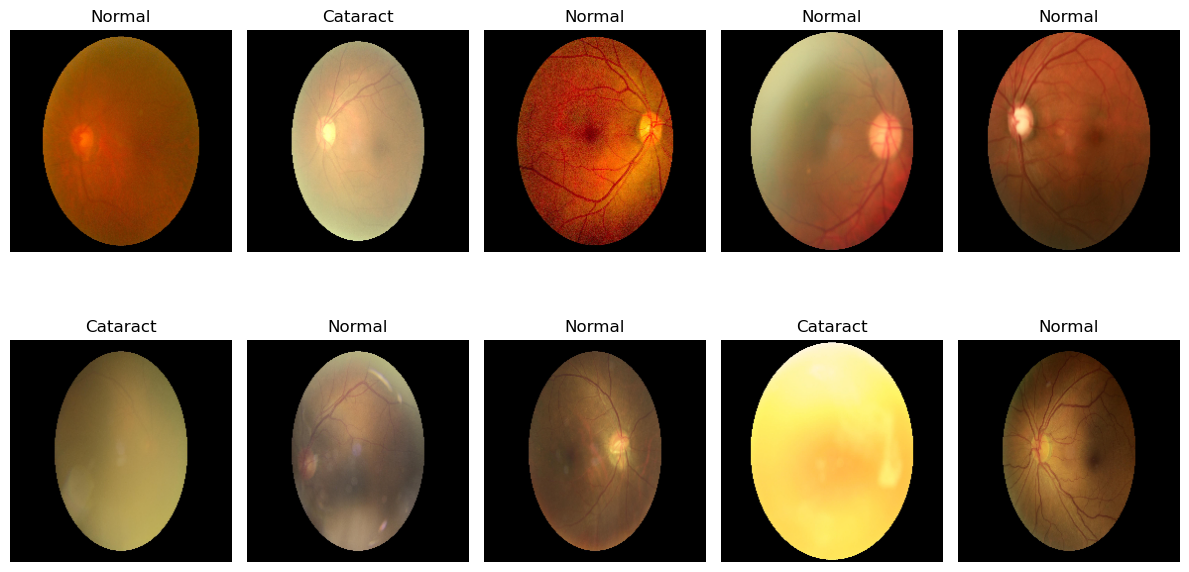

In [65]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 7))
for i in range(10):
    sample = random.choice(dataset)
    image, label = sample[0], sample[1]
    plt.subplot(2, 5, i + 1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB)) 
    plt.title("Cataract" if label == 1 else "Normal")
    plt.axis("off")
plt.tight_layout()
plt.show()


prepare data for training

In [66]:
X = np.array([i[0] for i in dataset]).reshape(-1, image_size, image_size, 3)  # Images
y = np.array([i[1] for i in dataset]) 

# Split into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training data: {X_train.shape}, {y_train.shape}")
print(f"Testing data: {X_test.shape}, {y_test.shape}")


Training data: (955, 224, 224, 3), (955,)
Testing data: (239, 224, 224, 3), (239,)


train model

# VGG-19

In [67]:
import time

In [68]:
from tensorflow.keras.applications.vgg19 import VGG19
vgg = VGG19(weights="imagenet",include_top = False,input_shape=(image_size,image_size,3))

In [69]:
for layer in vgg.layers:
    layer.trainable = False

In [70]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten,Dense
model = Sequential()
model.add(vgg)
model.add(Flatten())
model.add(Dense(1,activation="sigmoid"))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 dense_2 (Dense)             (None, 1)                 25089     
                                                                 
Total params: 20049473 (76.48 MB)
Trainable params: 25089 (98.00 KB)
Non-trainable params: 20024384 (76.39 MB)
_________________________________________________________________


In [71]:
start_time = time.time()

Epoch 1/5
30/30 [==============================] - ETA: 0s - loss: 2.0069 - accuracy: 0.8628
Epoch 1: val_accuracy improved from -inf to 0.94979, saving model to vgg19.h5
30/30 [==============================] - 138s 5s/step - loss: 2.0069 - accuracy: 0.8628 - val_loss: 0.5877 - val_accuracy: 0.9498
Epoch 2/5


/Users/nisha/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


30/30 [==============================] - ETA: 0s - loss: 0.6057 - accuracy: 0.9571
Epoch 2: val_accuracy did not improve from 0.94979
30/30 [==============================] - 133s 4s/step - loss: 0.6057 - accuracy: 0.9571 - val_loss: 1.1539 - val_accuracy: 0.9038
Epoch 3/5
30/30 [==============================] - ETA: 0s - loss: 0.1394 - accuracy: 0.9738
Epoch 3: val_accuracy improved from 0.94979 to 0.95816, saving model to vgg19.h5
30/30 [==============================] - 139s 5s/step - loss: 0.1394 - accuracy: 0.9738 - val_loss: 0.3272 - val_accuracy: 0.9582
Epoch 4/5
30/30 [==============================] - ETA: 0s - loss: 0.1123 - accuracy: 0.9801
Epoch 4: val_accuracy improved from 0.95816 to 0.96234, saving model to vgg19.h5
30/30 [==============================] - 131s 4s/step - loss: 0.1123 - accuracy: 0.9801 - val_loss: 0.2571 - val_accuracy: 0.9623
Epoch 5/5
30/30 [==============================] - ETA: 0s - loss: 0.0499 - accuracy: 0.9874
Epoch 5: val_accuracy improved from

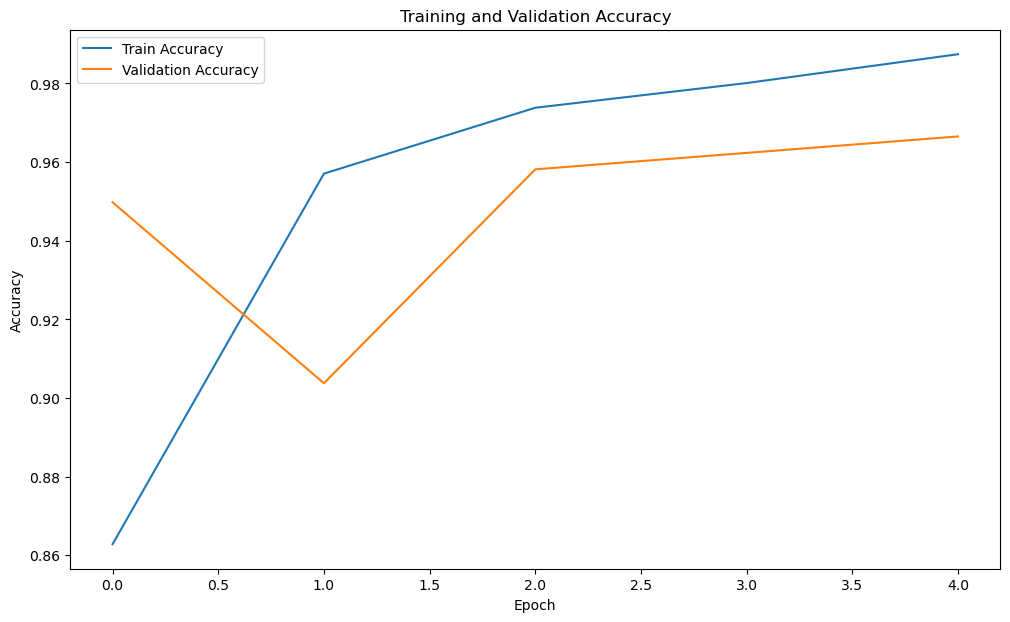

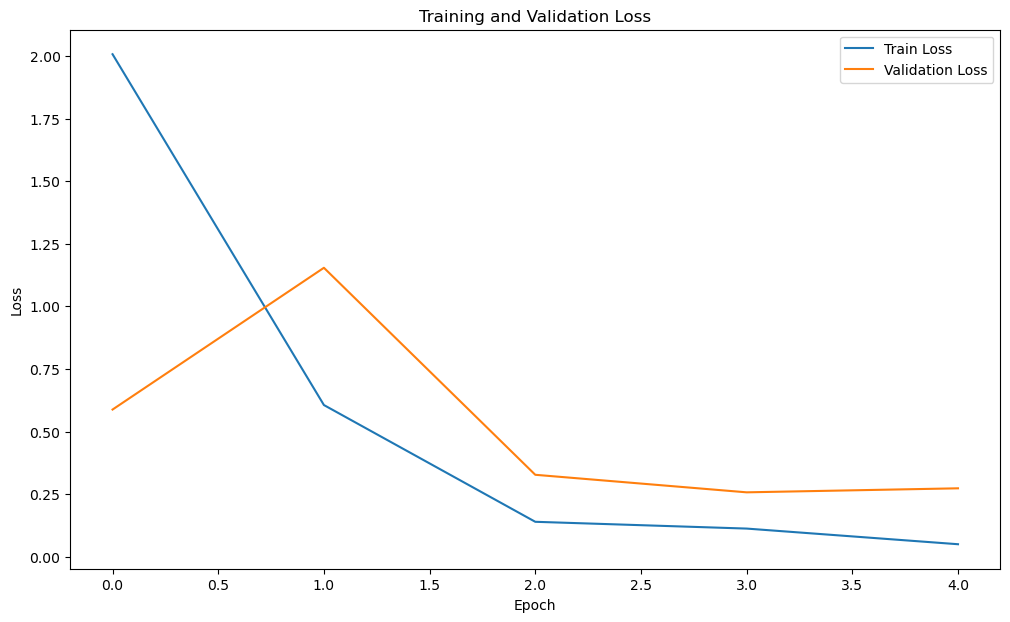

8/8 [==============================] - 26s 3s/step


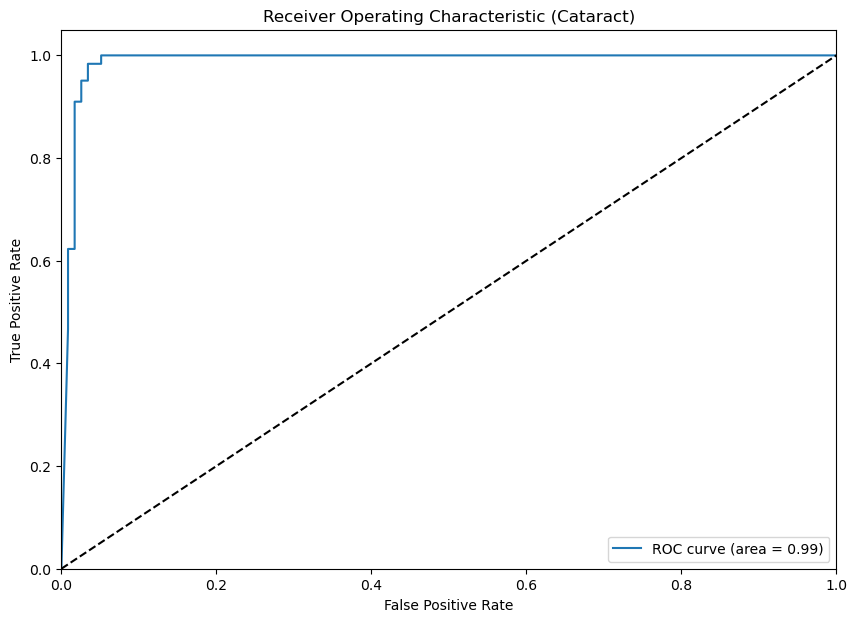

In [72]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np
import time

# Compile the model
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

# Define callbacks
checkpoint = ModelCheckpoint(
    "vgg19.h5",
    monitor="val_accuracy",  # Use 'val_accuracy' instead of 'val_acc'
    verbose=1,
    save_best_only=True,
    save_weights_only=False
)
earlystop = EarlyStopping(monitor="val_accuracy", patience=5, verbose=1)

# Train the model
start_time = time.time()
history = model.fit(
    X_train, y_train,
    batch_size=32,
    epochs=5,
    validation_data=(X_test, y_test),
    verbose=1,
    callbacks=[checkpoint, earlystop]
)
training_time = time.time() - start_time
print(f"Training Time: {training_time:.2f} seconds")

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

# Plot the training history
plt.figure(figsize=(12, 7))
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training and Validation Accuracy")
plt.show()

# Plot the training and validation loss
plt.figure(figsize=(12, 7))
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training and Validation Loss")
plt.show()

# Generate predictions on the testing set
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)

# Compute ROC curve and AUC
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(10, 7))
plt.plot(fpr, tpr, label="ROC curve (area = %0.2f)" % roc_auc)
plt.plot([0, 1], [0, 1], "k--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (Cataract)")
plt.legend(loc="lower right")
plt.show()

              precision    recall  f1-score   support

      Normal       0.97      0.97      0.97       117
    Cataract       0.97      0.97      0.97       122

    accuracy                           0.97       239
   macro avg       0.97      0.97      0.97       239
weighted avg       0.97      0.97      0.97       239

8/8 [==============================] - 25s 3s/step - loss: 0.2731 - accuracy: 0.9665
Test Loss: 0.2731495499610901
Test Accuracy: 0.9665272235870361


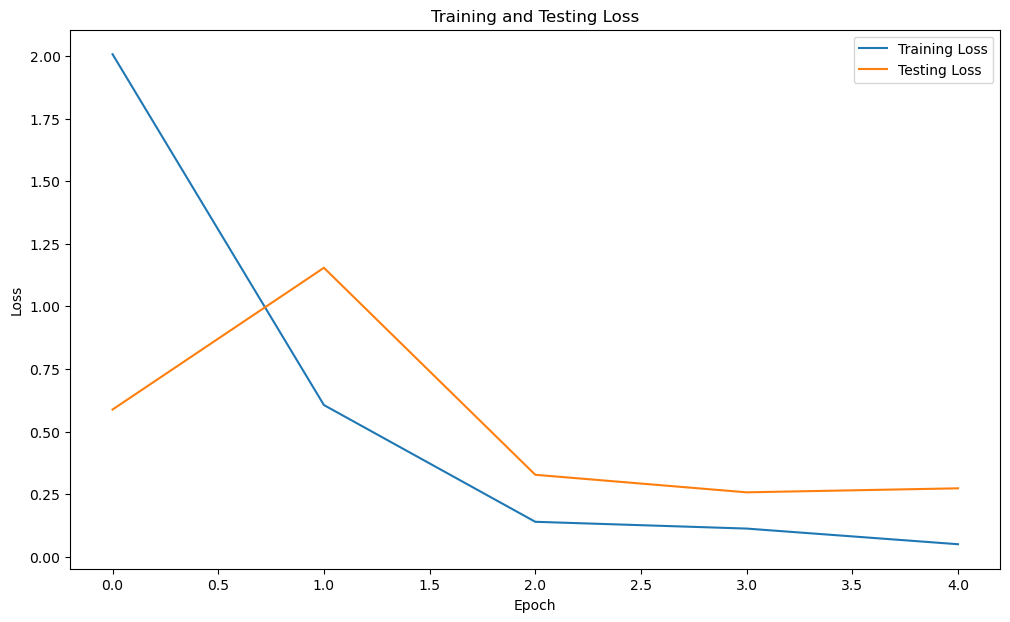

Training Time: 760.3370687961578 seconds


In [74]:
target_names = ['Normal', 'Cataract']
classification_rep = classification_report(y_test, y_pred_binary, target_names=target_names)
print(classification_rep)

test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

# Plot the training and validation loss
plt.figure(figsize=(12, 7))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Testing Loss')
plt.show()

# Calculate the training time
training_time = time.time() - start_time

# Print the training time
print('Training Time:', training_time, 'seconds')

COMPARING THE MODELS

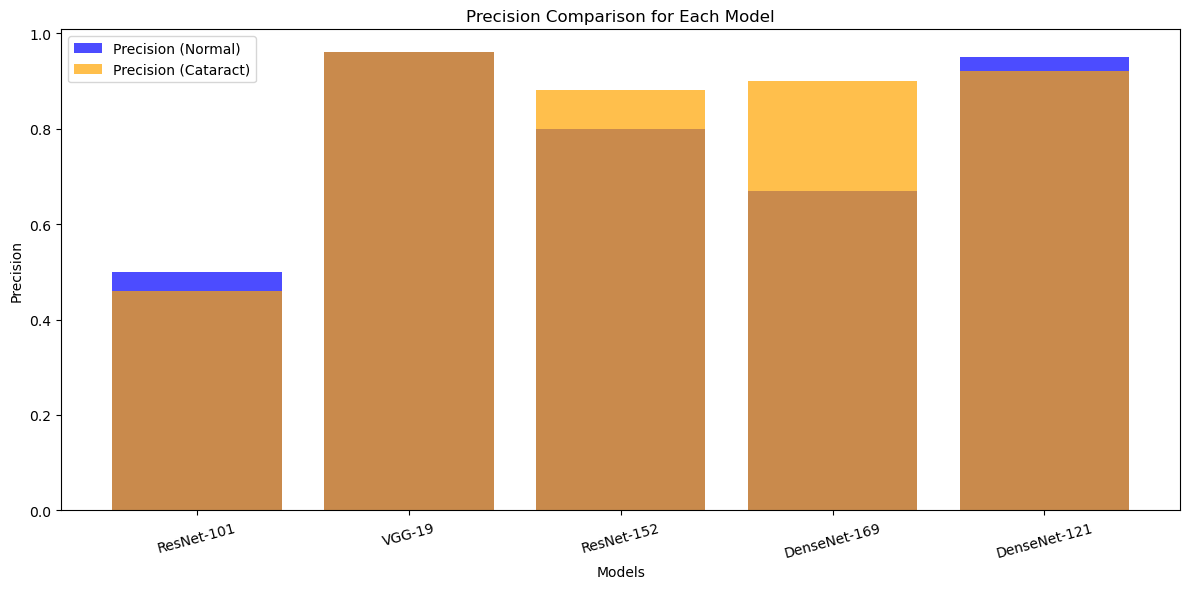

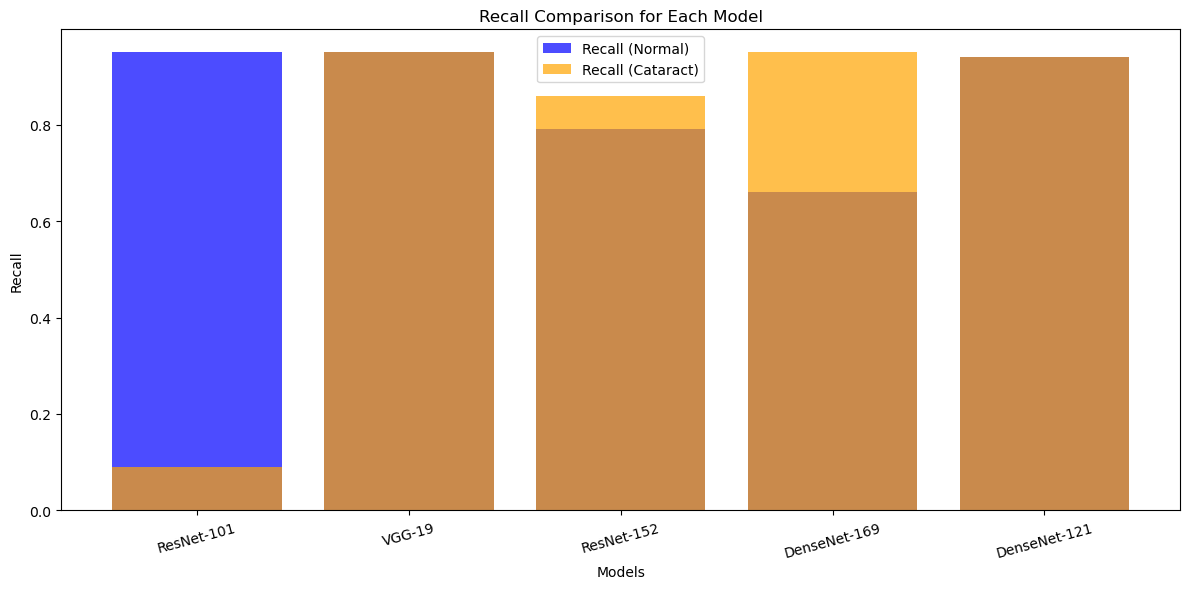

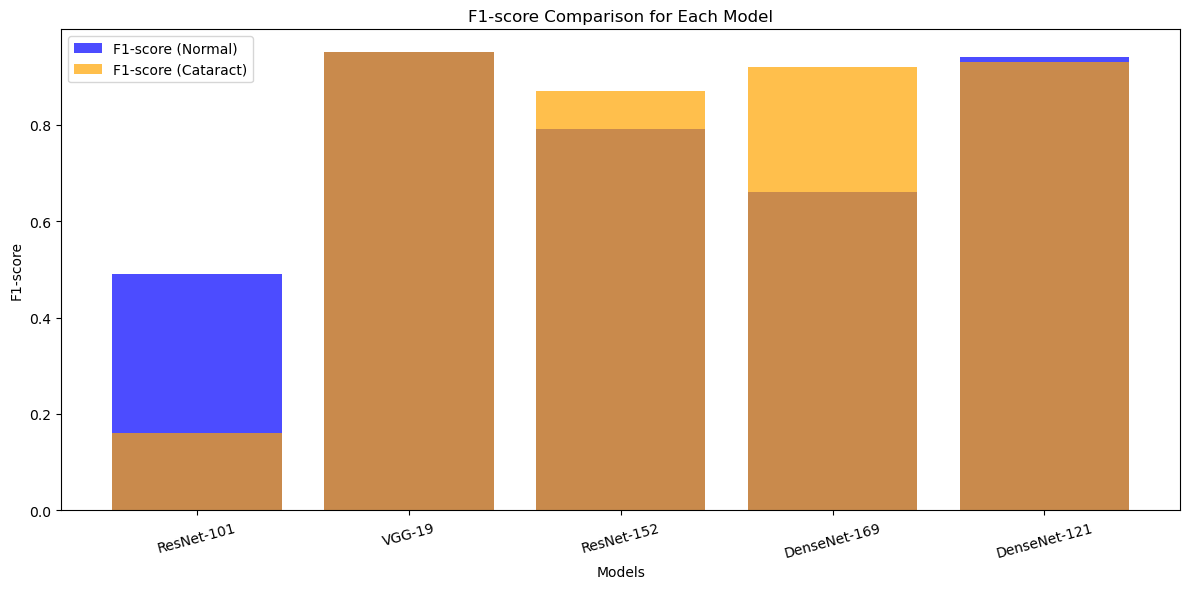

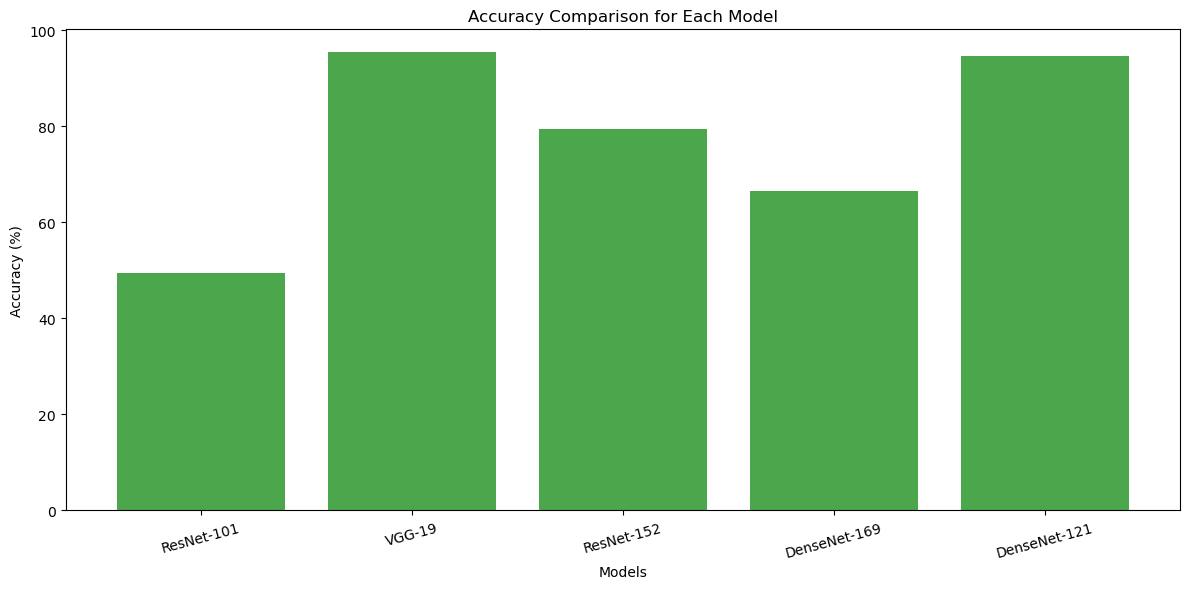

In [76]:
import matplotlib.pyplot as plt

models = ['ResNet-101', 'VGG-19', 'ResNet-152', 'DenseNet-169', 'DenseNet-121']
precision_normal = [0.50, 0.96, 0.80, 0.67, 0.95]
precision_cataract = [0.46, 0.96, 0.88, 0.90, 0.92]
recall_normal = [0.95, 0.95, 0.79, 0.66, 0.94]
recall_cataract = [0.09, 0.95, 0.86, 0.95, 0.94]
f1_score_normal = [0.49, 0.95, 0.79, 0.66, 0.94]
f1_score_cataract = [0.16, 0.95, 0.87, 0.92, 0.93]
accuracy = [49.4, 95.4, 79.5, 66.5, 94.6]


plt.figure(figsize=(12, 6))
plt.bar(models, precision_normal, label='Precision (Normal)', color='blue', alpha=0.7)
plt.bar(models, precision_cataract, label='Precision (Cataract)', color='orange', alpha=0.7)
plt.xlabel('Models')
plt.ylabel('Precision')
plt.title('Precision Comparison for Each Model')
plt.legend()
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
plt.bar(models, recall_normal, label='Recall (Normal)', color='blue', alpha=0.7)
plt.bar(models, recall_cataract, label='Recall (Cataract)', color='orange', alpha=0.7)
plt.xlabel('Models')
plt.ylabel('Recall')
plt.title('Recall Comparison for Each Model')
plt.legend()
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
plt.bar(models, f1_score_normal, label='F1-score (Normal)', color='blue', alpha=0.7)
plt.bar(models, f1_score_cataract, label='F1-score (Cataract)', color='orange', alpha=0.7)
plt.xlabel('Models')
plt.ylabel('F1-score')
plt.title('F1-score Comparison for Each Model')
plt.legend()
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
plt.bar(models, accuracy, color='green', alpha=0.7)
plt.xlabel('Models')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy Comparison for Each Model')
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()


In [77]:
import pandas as pd

data = {
    "Model": ["ResNet-101", "VGG-19", "ResNet-152", "DenseNet-169", "DenseNet-121"],
    "Precision (Normal)": precision_normal,
    "Precision (Cataract)": precision_cataract,
    "Recall (Normal)": recall_normal,
    "Recall (Cataract)": recall_cataract,
    "F1-score (Normal)": f1_score_normal,
    "F1-score (Cataract)": f1_score_cataract,
    "Accuracy (%)": accuracy
}

df = pd.DataFrame(data)

df_formatted = df.style.format({
    "Precision (Normal)": "{:.2f}",
    "Precision (Cataract)": "{:.2f}",
    "Recall (Normal)": "{:.2f}",
    "Recall (Cataract)": "{:.2f}",
    "F1-score (Normal)": "{:.2f}",
    "F1-score (Cataract)": "{:.2f}",
    "Accuracy (%)": "{:.2f}"
})

print("Model Performance Comparison Table:")
print(df)

df_formatted


Model Performance Comparison Table:
          Model  Precision (Normal)  Precision (Cataract)  Recall (Normal)  \
0    ResNet-101                0.50                  0.46             0.95   
1        VGG-19                0.96                  0.96             0.95   
2    ResNet-152                0.80                  0.88             0.79   
3  DenseNet-169                0.67                  0.90             0.66   
4  DenseNet-121                0.95                  0.92             0.94   

   Recall (Cataract)  F1-score (Normal)  F1-score (Cataract)  Accuracy (%)  
0               0.09               0.49                 0.16          49.4  
1               0.95               0.95                 0.95          95.4  
2               0.86               0.79                 0.87          79.5  
3               0.95               0.66                 0.92          66.5  
4               0.94               0.94                 0.93          94.6  


,Model,Precision (Normal),Precision (Cataract),Recall (Normal),Recall (Cataract),F1-score (Normal),F1-score (Cataract),Accuracy (%)
0,ResNet-101,0.50,0.46,0.95,0.09,0.49,0.16,49.40
1,VGG-19,0.96,0.96,0.95,0.95,0.95,0.95,95.40
2,ResNet-152,0.80,0.88,0.79,0.86,0.79,0.87,79.50
3,DenseNet-169,0.67,0.90,0.66,0.95,0.66,0.92,66.50
4,DenseNet-121,0.95,0.92,0.94,0.94,0.94,0.93,94.60


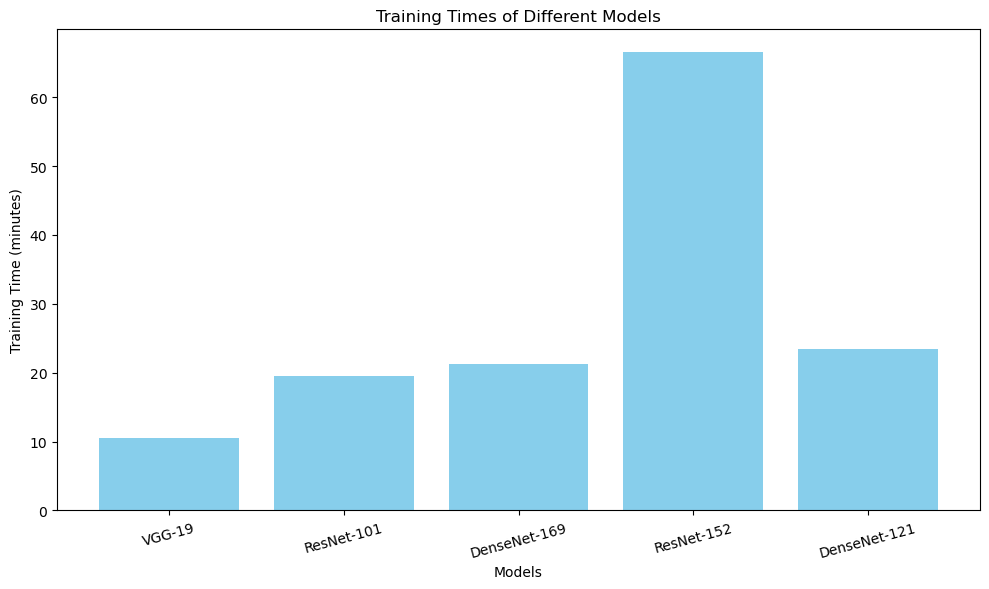

+--------------+-------------------------+
|    Model     | Training Time (minutes) |
+--------------+-------------------------+
|    VGG-19    |          10.55          |
|  ResNet-101  |          19.58          |
| DenseNet-169 |          21.27          |
|  ResNet-152  |          66.53          |
| DenseNet-121 |          23.45          |
+--------------+-------------------------+


In [78]:
import matplotlib.pyplot as plt
from prettytable import PrettyTable

models = ['VGG-19', 'ResNet-101', 'DenseNet-169', 'ResNet-152', 'DenseNet-121']
training_times = [633 / 60, (227 + 245 + 230 + 220 + 253) / 60, 
                  (203 + 171 + 170 + 179 + 187 + 198 + 168) / 60, 
                  (428 + 403 + 437 + 407 + 489 + 410 + 356 + 358 + 351 + 353) / 60, 
                  (148 + 138 + 141 + 138 + 137 + 135 + 137 + 143 + 139 + 151) / 60]

plt.figure(figsize=(10, 6))
plt.bar(models, training_times, color='skyblue')
plt.xlabel('Models')
plt.ylabel('Training Time (minutes)')
plt.title('Training Times of Different Models')
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

table = PrettyTable()
table.field_names = ["Model", "Training Time (minutes)"]

for model, time in zip(models, training_times):
    table.add_row([model, f"{time:.2f}"])

print(table)


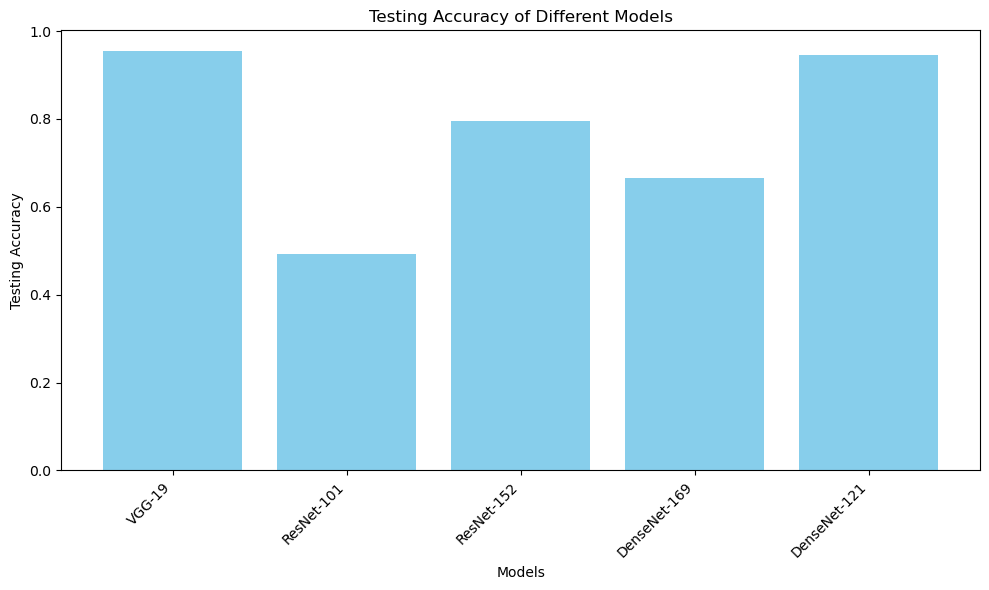

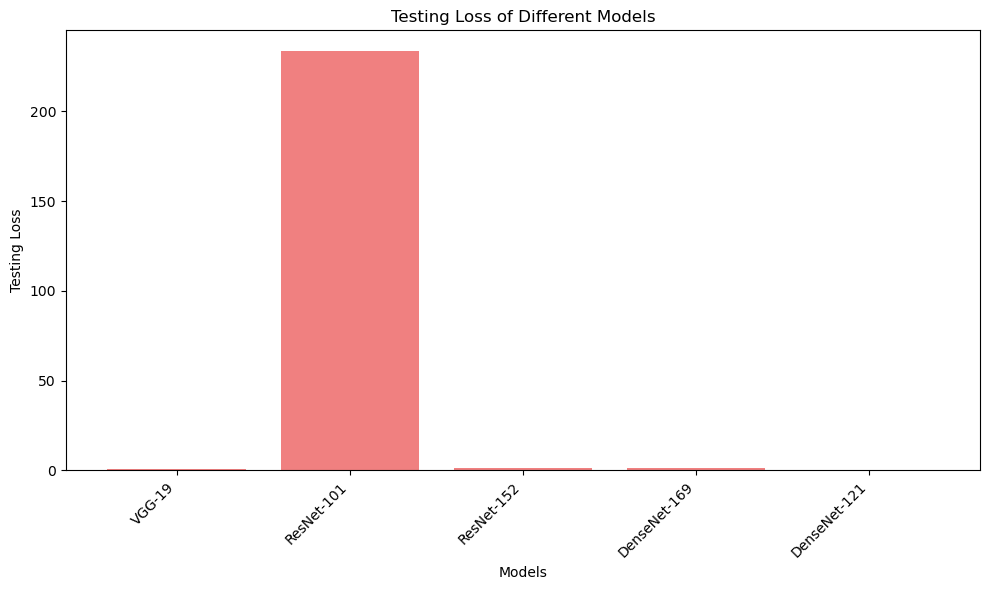

+--------------+------------------+--------------+
|    Model     | Testing Accuracy | Testing Loss |
+--------------+------------------+--------------+
|    VGG-19    |      0.9540      |    0.806     |
|  ResNet-101  |      0.4937      |   233.510    |
|  ResNet-152  |      0.7950      |    1.426     |
| DenseNet-169 |      0.6653      |    1.153     |
| DenseNet-121 |      0.9456      |    0.290     |
+--------------+------------------+--------------+


In [79]:
import matplotlib.pyplot as plt
from prettytable import PrettyTable

models = ['VGG-19', 'ResNet-101', 'ResNet-152', 'DenseNet-169', 'DenseNet-121']
test_accuracy = [0.9540, 0.4937, 0.7950, 0.6653, 0.9456]
test_loss = [0.8065, 233.51, 1.426, 1.153, 0.290]

plt.figure(figsize=(10, 6))
plt.bar(models, test_accuracy, color='skyblue')
plt.xlabel('Models')
plt.ylabel('Testing Accuracy')
plt.title('Testing Accuracy of Different Models')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
plt.bar(models, test_loss, color='lightcoral')
plt.xlabel('Models')
plt.ylabel('Testing Loss')
plt.title('Testing Loss of Different Models')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

table = PrettyTable()
table.field_names = ["Model", "Testing Accuracy", "Testing Loss"]

for model, accuracy, loss in zip(models, test_accuracy, test_loss):
    table.add_row([model, f"{accuracy:.4f}", f"{loss:.3f}"])

print(table)


Performance Metrics of Different Models:

In [80]:
import pandas as pd
from IPython.display import display

# Data provided for the table
data = {
    "Model": ["ResNet-101", "VGG-19", "ResNet-152", "DenseNet-169", "DenseNet-121"],
    "Accuracy (%)": [49.4, 95.4, 79.5, 66.5, 94.6],
    "Precision (Normal)": [0.50, 0.96, 0.80, 0.67, 0.95],
    "Precision (Cataract)": [0.46, 0.96, 0.88, 0.90, 0.92],
    "Recall (Normal)": [0.95, 0.95, 0.79, 0.66, 0.94],
    "Recall (Cataract)": [0.09, 0.95, 0.86, 0.95, 0.94],
    "F1-Score (Normal)": [0.49, 0.95, 0.79, 0.66, 0.94],
    "F1-Score (Cataract)": [0.16, 0.95, 0.87, 0.92, 0.93],
}

# Create the DataFrame
metrics_df = pd.DataFrame(data)

# Format numerical columns to 2 decimal places
metrics_df = metrics_df.style.format({
    "Accuracy (%)": "{:.1f}",
    "Precision (Normal)": "{:.2f}",
    "Precision (Cataract)": "{:.2f}",
    "Recall (Normal)": "{:.2f}",
    "Recall (Cataract)": "{:.2f}",
    "F1-Score (Normal)": "{:.2f}",
    "F1-Score (Cataract)": "{:.2f}"
})

# Display the table
print("Performance Metrics of Different Models:")
display(metrics_df)


Performance Metrics of Different Models:


,Model,Accuracy (%),Precision (Normal),Precision (Cataract),Recall (Normal),Recall (Cataract),F1-Score (Normal),F1-Score (Cataract)
0,ResNet-101,49.4,0.50,0.46,0.95,0.09,0.49,0.16
1,VGG-19,95.4,0.96,0.96,0.95,0.95,0.95,0.95
2,ResNet-152,79.5,0.80,0.88,0.79,0.86,0.79,0.87
3,DenseNet-169,66.5,0.67,0.90,0.66,0.95,0.66,0.92
4,DenseNet-121,94.6,0.95,0.92,0.94,0.94,0.94,0.93


In [101]:
import pandas as pd
from IPython.display import display

# Data for the table
data = {
    "Model Name": ["VGG-19", "ResNet-101", "ResNet-152", "DenseNet-169", "DenseNet-121"],
    "Test Loss": [0.8065, 233.51, 1.426, 1.153, 0.290],
    "Test Accuracy (%)": [95.4, 49.4, 79.5, 66.5, 94.6]
}

# Create a DataFrame
model_performance = pd.DataFrame(data)

# Display the table
print("Model Performance Comparison:")
display(model_performance)


Model Performance Comparison:


,Model Name,Test Loss,Test Accuracy (%)
0,VGG-19,0.8065,95.4
1,ResNet-101,233.5100,49.4
2,ResNet-152,1.4260,79.5
3,DenseNet-169,1.1530,66.5
4,DenseNet-121,0.2900,94.6


AUROC

In [129]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [98]:
print("y_test shape:", y_test.shape)
print("y_pred_proba shape:", y_pred_proba.shape)


y_test shape: (239,)
y_pred_proba shape: (239, 1)


In [99]:
y_pred_proba = y_pred_proba.ravel()


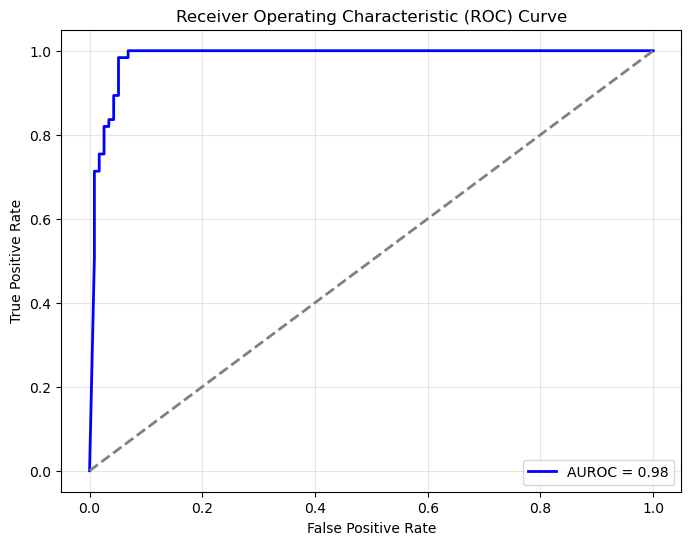

In [100]:
y_pred_proba = y_pred_proba.ravel()

assert len(y_test) == len(y_pred_proba), "Mismatch in y_test and y_pred_proba lengths!"

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plotting AUROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'AUROC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)  # Diagonal line
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()


In [132]:
from sklearn.metrics import roc_auc_score

# Exclude VGG-19 from model_predictions
filtered_model_predictions = {model: predictions for model, predictions in model_predictions.items() if model != "VGG-19"}

# Calculate AUROC scores for the filtered models
auroc_scores = {}
for model, predictions in filtered_model_predictions.items():
    auroc = roc_auc_score(y_true, predictions)
    auroc_scores[model] = auroc

print("AUROC Scores (excluding VGG-19):", auroc_scores)



AUROC Scores (excluding VGG-19): {'ResNet101': 0.72, 'ResNet152': 0.72, 'DenseNet169': 0.76, 'DenseNet121': 0.72}


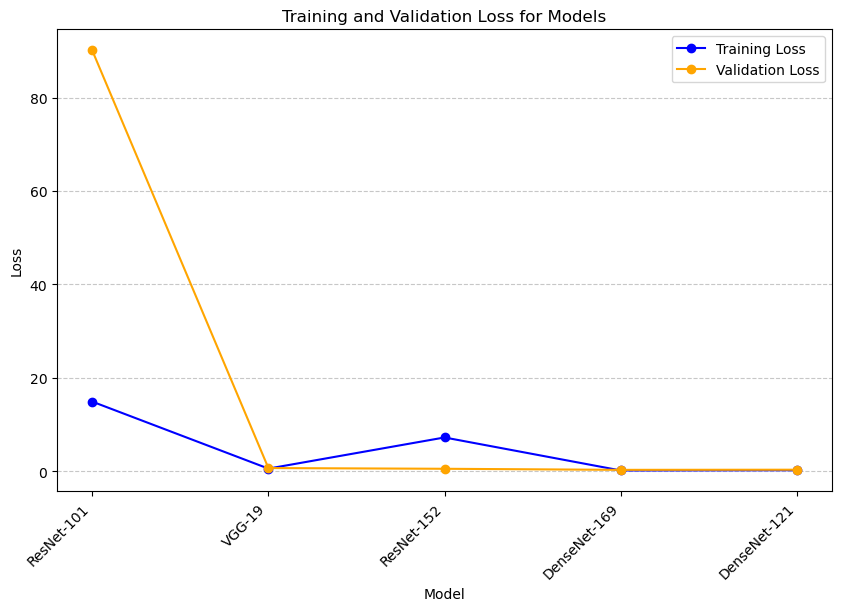

In [83]:
import matplotlib.pyplot as plt

# Data for loss (based on updated model order)
models = ["ResNet-101", "VGG-19", "ResNet-152", "DenseNet-169", "DenseNet-121"]
train_loss = [14.91, 0.574, 7.24, 0.1758, 0.228]  
val_loss = [90.08, 0.692, 0.537, 0.3064, 0.338]   

# Plot training and validation losses
plt.figure(figsize=(10, 6))
plt.plot(models, train_loss, label="Training Loss", marker='o', color='blue')
plt.plot(models, val_loss, label="Validation Loss", marker='o', color='orange')
plt.title("Training and Validation Loss for Models")
plt.xlabel("Model")
plt.ylabel("Loss")
plt.legend()
plt.xticks(rotation=45, ha='right')  
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add gridlines for clarity
plt.show()


In [133]:
# Assuming `history` is the history object returned by `model.fit`
val_accuracy = history.history['val_accuracy']  # List of validation accuracies for each epoch

# Print all validation accuracies
print("Validation Accuracy for each epoch:", val_accuracy)

# Get the final validation accuracy (accuracy of the last epoch)
final_val_accuracy = val_accuracy[-1] if val_accuracy else None
print(f"Final Validation Accuracy: {final_val_accuracy:.2f}")


Validation Accuracy for each epoch: [0.9497907757759094, 0.9037656784057617, 0.9581589698791504, 0.9623430967330933, 0.9665272235870361]
Final Validation Accuracy: 0.97


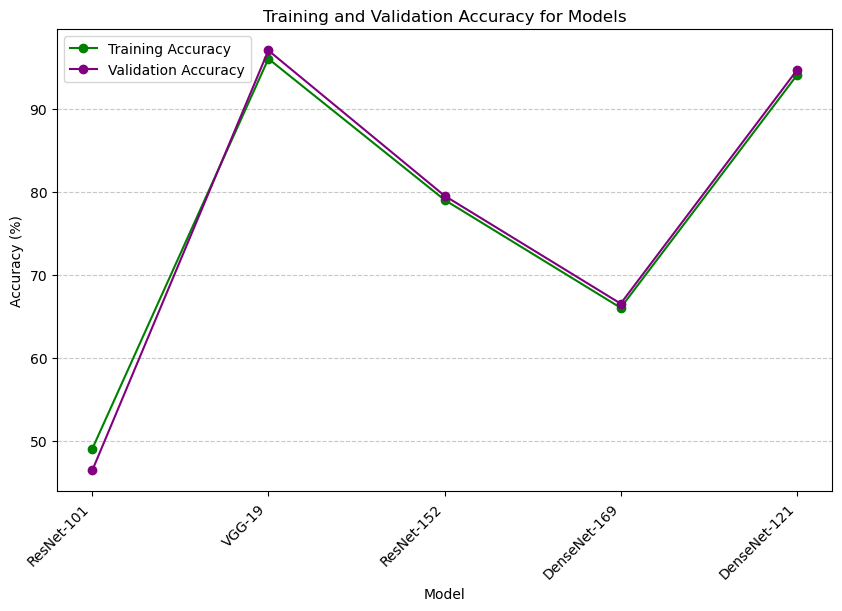

In [135]:
import matplotlib.pyplot as plt

models = ["ResNet-101", "VGG-19", "ResNet-152", "DenseNet-169", "DenseNet-121"]
train_accuracy = [49.0, 96.0, 79.0, 66.0, 94.0] 
val_accuracy = [46.4, 97.0, 79.5, 66.5, 94.6]   

plt.figure(figsize=(10, 6))
plt.plot(models, train_accuracy, label="Training Accuracy", marker='o', color='green')
plt.plot(models, val_accuracy, label="Validation Accuracy", marker='o', color='purple')
plt.title("Training and Validation Accuracy for Models")
plt.xlabel("Model")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.xticks(rotation=45, ha='right')  
plt.grid(axis='y', linestyle='--', alpha=0.7)  
plt.show()


BEST MODEL

In [85]:
from tensorflow.keras.models import load_model

best_model_path = "vgg19_fold3.h5" 
best_model = load_model(best_model_path)

test_loss, test_acc = best_model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")


8/8 [==============================] - 25s 3s/step - loss: 0.0088 - accuracy: 0.9958
Test Loss: 0.0088
Test Accuracy: 0.9958


1/1 [==============================] - 0s 176ms/step


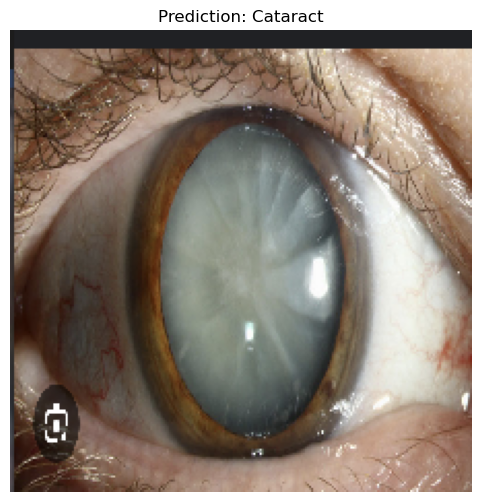

The prediction for the image is: Cataract


In [86]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt

def predict_cataract(image_path, model, image_size=224):
   
    image = load_img(image_path, target_size=(image_size, image_size))
    image_array = img_to_array(image) / 255.0  
    image_batch = np.expand_dims(image_array, axis=0) 

    prediction = model.predict(image_batch)[0][0]
    result = "Cataract" if prediction > 0.5 else "Normal"

    plt.figure(figsize=(6, 6))
    plt.imshow(image)
    plt.title(f"Prediction: {result}")
    plt.axis("off")
    plt.show()

    return result

image_path = "cat.png" 
result = predict_cataract(image_path, best_model)
print(f"The prediction for the image is: {result}")


1/1 [==============================] - 0s 151ms/step


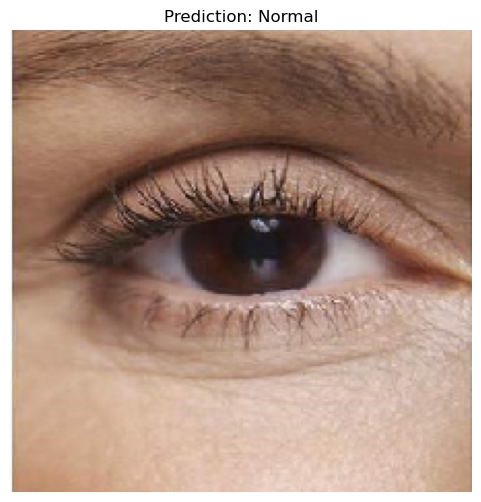

The prediction for the image is: Normal


In [87]:
def predict_cataract(image_path, model, image_size=224):
   
    image = load_img(image_path, target_size=(image_size, image_size))
    image_array = img_to_array(image) / 255.0  
    image_batch = np.expand_dims(image_array, axis=0) 

    prediction = model.predict(image_batch)[0][0]
    result = "Cataract" if prediction > 0.5 else "Normal"

    plt.figure(figsize=(6, 6))
    plt.imshow(image)
    plt.title(f"Prediction: {result}")
    plt.axis("off")
    plt.show()

    return result

image_path = "nor_2.png" 
result = predict_cataract(image_path, best_model)
print(f"The prediction for the image is: {result}")


In [88]:
import json

input_file = "NNDL_final_project.ipynb"
output_file = "NNDL_finalproject-2.txt"

try:
    with open(input_file, "r", encoding="utf-8") as f:
        notebook_content = json.load(f)

    # Extract code cells and write to a .txt file
    with open(output_file, "w", encoding="utf-8") as f:
        for cell in notebook_content.get("cells", []):
            if cell.get("cell_type") == "code":
                f.write("".join(cell.get("source", [])) + "\n\n")
    
    result_message = f"Notebook '{input_file}' has been successfully converted to '{output_file}'."
except Exception as e:
    result_message = f"An error occurred: {e}"

result_message

"Notebook 'NNDL_final_project.ipynb' has been successfully converted to 'NNDL_finalproject-2.txt'."